# European Football Match Modeling
> Creating a model that outperforms the oddsmakers

- toc: false
- badges: true
- comments: true
- categories: [soccer, machine learning, xgboost]

Last year, I published my work on [predicting Major League Baseball](https://rdpharr.github.io/project_notes/baseball/benchmark/webscraping/brier/accuracy/calibration/machine%20learning/2020/09/20/baseball_project.html) outcomes. This model uses the same formula, but improves it in several ways. First of all it's about half the size and code, which has to be a relief. More importantly it gives us better results. The recipe is the same:
 - Download all the match data ([previous notebook](https://rdpharr.github.io/project_notes/soccer/benchmark/brier/accuracy/calibration/machine%20learning/2020/12/26/eurofootball_odds_analysis.html))
 - Download all of the odds data from a casino aggregator ([previous notebook](https://rdpharr.github.io/project_notes/soccer/machine%20learning/webscraping/2021/01/03/eurofootball_match_scraper.html))
 - Transform the data in 3 ways:
     - Calculate which team usually has better stats
     - Assign a skill ranking to each team, like they do for chess or online video game players
     - Add the odds data from the aggregator
 - Feed the resulting dataset into xgboost, with some tuning of hyperparameters

Et voila, when we are done we have a model that can be used for prediction. That is what this notebook will cover, with some analysis of model performance at the end. I won't cover my prediction process, as it's pretty much the same as I [described last year](https://rdpharr.github.io/project_notes/baseball/webscraping/kelly%20criterion/xgboost/machine%20learning/2020/09/26/predictions-and-betting-strategy.html) in the baseball model.

> Important: This blog post is executable. Use the buttons at the top to run the code on Binder of Colab and get fresh results for yourself. You can also download it from Github to run the notebook locally.

> Important: This notebook depends on files from the previous notebooks linked above. You'll need to run those and save the resulting files to use this notebook.

In [1]:
#collapse-hide

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import shap
import xgboost as xgb

from elote import GlickoCompetitor
from fuzzywuzzy import process
from sklearn.metrics import classification_report, brier_score_loss, f1_score
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

## Get and clean the historical game data

The first thing is to get eh historic game data that was preduced in a [previous notebook](https://rdpharr.github.io/project_notes/soccer/benchmark/brier/accuracy/calibration/machine%20learning/2020/12/26/eurofootball_odds_analysis.html). You can see it's mostly numeric w/ 6 objects and takes up 12M of memory on my machine.

In [2]:
df = pd.read_csv('matches.csv.gzip', compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6165 entries, 0 to 6164
Columns: 257 entries, game_id to home_carries_into_penalty_area
dtypes: float64(52), int64(199), object(6)
memory usage: 12.1+ MB


Really we should only have 3 strings in the data: home team, away team and game_id. What are the rest?

In [3]:
df.select_dtypes(include=['object']).columns

Index(['game_id', 'date', 'game_time', 'away_team', 'home_team', 'home_score'], dtype='object')

The below code puts date & time into one column, and fixes home_score, which for some unknown reason was imported as a string.

In [4]:
# fix dtypes
df['home_score'] = pd.to_numeric(df['home_score'], errors='coerce')
df.dropna(subset=['home_score','away_score'], inplace=True)

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['game_time'])
df.drop(columns=['date','game_time'], inplace=True)
df.dtypes.value_counts()

int64             199
float64            53
object              3
datetime64[ns]      1
dtype: int64

The other thing that happened when I downloaded this dataset was that some of the team names had the character '�' in them. The code below fixes those using the excellent [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy) string matching package. 

In [5]:
# repair names
def name_repair(x):
    if '�' in x:
        return process.extract(x,df.home_team.unique(), limit=2)[1][0]
    else:
        return x
df['home_team'] = df['home_team'].apply(lambda x: name_repair(x))
df['away_team'] = df['away_team'].apply(lambda x: name_repair(x))

Lastly, let's downcast the dataset to save memory. Going from 64bit values to 32bit saves us half the memory and generally makes the work go faster.

In [6]:
def downcast(df):
    for x in df.select_dtypes(include=['float','int']).columns:
        df[x]=pd.to_numeric(df[x], downcast='float')
    return df
df = downcast(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6164 entries, 0 to 6164
Columns: 256 entries, game_id to datetime
dtypes: datetime64[ns](1), float32(252), object(3)
memory usage: 6.2+ MB


I want to add one more stat before we get started. These columns show which team won the on points or on expected goals.

In [7]:
# add outcomes for calculating team histories
df['home_win'] = (df['home_score']>df['away_score']).astype('float')
df['home_draw']= (df['home_score']==df['away_score']).astype('float')
df['away_win'] = (df['home_score']<df['away_score']).astype('float')
df['away_draw']= (df['home_score']==df['away_score']).astype('float')
df['home_win_xg'] = (df['home_score_xg']>df['away_score_xg']).astype('float')
df['away_win_xg'] = (df['home_score_xg']<df['away_score_xg']).astype('float')

## Which team <span style="color:blue">**usually**</span> has <span style="color:green">**better stats**</span>?

This is really the core idea of this model. We can take the large number of stats kept about each game and feed them into the model by asking with a simple transformation: calculating which team usually has better stats.

- <span style="color:green">**Better Stats**</span>: We'll compare stats of two teams by subtacting each team's <span style="color:blue">usual</span> stat.
- <span style="color:blue">**Usual**</span>: This word has to mean some average of the historical stat for the team. After trying a bunch of ways, I've landed on [Exponetially Weighted Average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) as my preference.

Implementing this calculating is a multistep process. The first step is to stack the team statistics. Currently each match is one row with the home stats and away stat columns prefixied by "home_" or "away_" respectively. We need to stack them so that home and way teams are on separate rows.

In [8]:
# stack team data
base_columns = ['game_id','datetime']
home_columns = [x for x in df.columns if 'home_' in x]
away_columns = [x for x in df.columns if 'away_' in x]
len(away_columns), len(home_columns), len(df.columns)

(130, 130, 262)

We can see there are 129 statistics for each team in each game (130 with the team name).

In [9]:
home_df = df[base_columns + home_columns].copy().reset_index(drop=True)
home_df.columns = base_columns + [x[5:] for x in home_columns] # get rid of "home_" prefix
home_df["is_home_team"]=True

away_df = df[base_columns + away_columns].copy().reset_index(drop=True)
away_df.columns = base_columns + [x[5:] for x in away_columns] # get rid of "away_" prefix
away_df["is_home_team"]=False

#stack the two dfs together to make one big one
stat_df = pd.concat([away_df,home_df]).sort_values(by='datetime').reset_index(drop=True)
stat_df.shape

(12328, 133)

Now we have the long form dataframe with "game_id", "team", "is_home_team", "datetime" and the 129 statistics. Now we can calculate the Exponetially Weighted Average using [pandas.DataFrame.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)

In [10]:
stat_df = stat_df.sort_values(by='datetime').reset_index(drop=True)
stat_cols = [x for x in stat_df.columns if 'float' in str(stat_df[x].dtype)]

# exponentially weighted moving (ewm) average of each stat
for s in stat_cols:
    stat_df[s+'_ewm'] = stat_df.groupby('team')[s].transform(lambda x:x.ewm(span=10).mean())

stat_df.tail()

,game_id,datetime,team,score,score_xg,minutes,passes_completed,passes,passes_pct,passes_total_distance,...,crosses_stopped_gk_ewm,crosses_stopped_pct_gk_ewm,def_actions_outside_pen_area_gk_ewm,avg_distance_def_actions_gk_ewm,progressive_carries_ewm,carries_into_final_third_ewm,carries_into_penalty_area_ewm,win_ewm,draw_ewm,win_xg_ewm
12323,Villarreal-Granada-January-20-2021-La-Liga,2021-01-20 21:30:00,Granada,2.0,0.2,989.0,227.0,316.0,71.800003,4599.0,...,1.164333,12.142904,0.981302,14.601805,17.549999,4.100000,2.900000,0.421667,0.250260,0.301829
12324,Valencia-Osasuna-January-21-2021-La-Liga,2021-01-21 19:00:00,Osasuna,1.0,1.2,990.0,268.0,359.0,74.699997,5904.0,...,1.003265,8.387432,1.134634,15.613114,33.400002,8.600000,2.100000,0.078420,0.600918,0.452652
12325,Valencia-Osasuna-January-21-2021-La-Liga,2021-01-21 19:00:00,Valencia,1.0,0.7,990.0,524.0,636.0,82.400002,11003.0,...,1.166096,7.491065,0.601986,13.587904,59.000000,17.000000,2.000000,0.214238,0.498456,0.339046
12326,Liverpool-Burnley-January-21-2021-Premier-League,2021-01-21 20:00:00,Burnley,1.0,1.4,990.0,182.0,280.0,65.000000,4307.0,...,1.814314,14.459406,1.320769,15.413902,25.355482,8.837210,1.803987,0.427791,0.131629,0.224939
12327,Liverpool-Burnley-January-21-2021-Premier-League,2021-01-21 20:00:00,Liverpool,0.0,2.4,990.0,604.0,736.0,82.099998,11655.0,...,1.448721,15.356124,1.227189,14.979864,83.050003,26.700001,7.450000,0.244784,0.438290,0.878756


Since we know that our statistics are post-match, we want to shift them so that each row is pre-match. This ensures that the model learn to predict the outcome based on pre-match data.

In [11]:
# shift results so that each row is  a pregame stat
stat_cols = [x for x in stat_df.columns if 'float' in str(stat_df[x].dtype)]
stat_df = stat_df.sort_values(by='datetime').reset_index(drop=True)
for s in stat_cols:
    stat_df[s] = stat_df.groupby('team')[s].shift(1)

Finally, we can calculate the difference between the matched team splitting our stat_df into home and away dataframes and then using pandas.DataFrame.subtract to get the difference.

In [12]:
# calculate differences in pregame stats from home vs. away teams
away_df = stat_df[~stat_df['is_home_team']].copy()
away_df = away_df.set_index('game_id')
away_df = away_df[stat_cols]

home_df = stat_df[stat_df['is_home_team']].copy()
home_df = home_df.set_index('game_id')
home_df = home_df[stat_cols]

diff_df = home_df.subtract(away_df, fill_value=0)
diff_df = diff_df.reset_index()
diff_df.shape

(6164, 259)

After all of this we're left with the **diff_df** dataframe, which contains "game_id", 129 columns for difference of the **_ususal_** stats (indicated by the suffix "ewm") and 129 coumns for the difference in performance in the previous game (without suffix). 

That was the hard part. The rest is relatively straightforward.

## Create our training_df and add our features into it

Our training dataframe is going to be called "game_df". It will be based on our originally imported "df". We'll start is out with a few identifying features and add the "target" column, which will be what we train our model to predict.

In [13]:
game_df = df[['game_id','datetime','home_team','away_team']].copy()
game_df['target'] = 'H'
game_df['target'][df['home_score']==df['away_score']]='D'
game_df['target'][df['home_score']<df['away_score']]='A'
game_df.shape

(6164, 5)

The first feature we'll apply is the difference in skill rankings. For this, we'll use the excellent [elote](https://github.com/helton-tech/elote). This is the ranking system originally invented to rank competitive chess players in the 1940's, but has been iterated and expanded since. Most of the variations of the algorithm will work for our purposes, below I've implemented the [Glicko ranking algorithm](https://en.wikipedia.org/wiki/Glicko_rating_system) as it tends to see a lot of modern usage.

It's probably worth testing some of the others (Elo, Trueskill) to see if they offer any improvement. I haven't done that yet.

In [14]:
# skill rankings
ratings = {}
for x in df.home_team.unique():
    ratings[x]=GlickoCompetitor()

home_team_glick = []
away_team_glick = []

game_df = game_df.sort_values(by='datetime').reset_index(drop=True)
for i, r in game_df.iterrows():
    # pregame ratings will be used for our stats
    home_team_glick.append(ratings[r.home_team].rating)
    away_team_glick.append(ratings[r.away_team].rating)
    # update ratings
    if r['target'] == 'H':
        ratings[r.home_team].beat(ratings[r.away_team])
        ratings[r.away_team].lost_to(ratings[r.home_team])
    elif r['target'] == 'D':
        ratings[r.home_team].tied(ratings[r.away_team])
        ratings[r.away_team].tied(ratings[r.home_team])
    else:
        ratings[r.home_team].lost_to(ratings[r.away_team])
        ratings[r.away_team].beat(ratings[r.home_team])


game_df['glicko_diff'] = pd.Series(home_team_glick)-pd.Series(away_team_glick)
game_df.shape

(6164, 6)

Next the big pile of historical match stats gets merged in.

In [15]:
# merge in diff_df
game_df = pd.merge(left=game_df, right=diff_df, on='game_id', how='left')
game_df.shape

(6164, 264)

### Odds Data

Switch to william hill odds

In [16]:
odds_df = pd.read_csv("football_odds.csv.gzip", compression='gzip')

# add one hour for times to match times in game_df
odds_df['Date'] = pd.to_datetime(odds_df['Date'], dayfirst=True).dt.date
odds_df.drop(columns=['Time'], inplace=True)

# filter to just the data we'll need: odds from William Hill 
odds_df = odds_df[['HomeTeam','AwayTeam','Date','WHH','WHD','WHA']]
odds_df.columns = ['HomeTeam','AwayTeam','Date','OddsH','OddsD','OddsA']

# convert to percentages
for x in ['OddsH','OddsD','OddsA']:
    odds_df[x]=1/odds_df[x]

odds_df.shape

(6277, 6)

In [17]:
odds_teams = odds_df.HomeTeam.unique()
teams = game_df.home_team.unique()
lookup = []
for t in teams:
    if t == 'Athletic Club':
        lookup.append({
            'team': t,
            'HomeTeam': 'Ath Bilbao'
        })
    else:
        lookup.append({
            'team': t,
            'HomeTeam': process.extractOne(t,odds_teams)[0]
        })
lookup_df = pd.DataFrame(lookup)
lookup_df.head()

,team,HomeTeam
0,Monaco,Monaco
1,Paris Saint-Germain,Paris SG
2,Saint-Étienne,St Etienne
3,Montpellier,Montpellier
4,Metz,Metz


In [18]:
odds_df = pd.merge(left=odds_df, right=lookup_df, on='HomeTeam', how='left')
odds_df

,HomeTeam,AwayTeam,Date,OddsH,OddsD,OddsA,team
0,Eibar,Celta,2020-09-12,0.392157,0.322581,0.333333,Eibar
1,Granada,Ath Bilbao,2020-09-12,0.357143,0.333333,0.363636,Granada
2,Cadiz,Osasuna,2020-09-12,0.357143,0.344828,0.347222,Cádiz
3,Alaves,Betis,2020-09-13,0.357143,0.312500,0.381679,Alavés
4,Valladolid,Sociedad,2020-09-13,0.344828,0.312500,0.392157,Valladolid
...,...,...,...,...,...,...,...
6386,Nantes,Strasbourg,2018-05-19,0.546448,0.285714,0.230947,Nantes
6387,Rennes,Montpellier,2018-05-19,0.523560,0.312500,0.222222,Rennes
6388,St Etienne,Lille,2018-05-19,0.636943,0.263158,0.166667,Saint-Étienne
6389,Toulouse,Guingamp,2018-05-19,0.636943,0.263158,0.166667,Toulouse


In [19]:
game_df['Date'] = game_df['datetime'].dt.date
game_df = pd.merge(left=game_df, right=odds_df[['Date', 'OddsH', 'OddsD', 'OddsA', 'team']],
                  left_on= ['home_team','Date'], right_on=['team','Date'],
                  how='left')
game_df.drop(columns=['Date','team'], inplace=True)

# dropgames with na odds
print(game_df[['OddsH', 'OddsD', 'OddsA']].isna().sum())
game_df.dropna(subset=['OddsH', 'OddsD', 'OddsA'], inplace=True)

OddsH    46
OddsD    46
OddsA    46
dtype: int64


### Final features

In [20]:
# datetime feats
game_df['month']=game_df['datetime'].dt.month
game_df['dow']=game_df['datetime'].dt.weekday
game_df['is_night_game'] = game_df['datetime'].dt.hour>18
game_df['datetime'] = game_df['datetime'].astype('int')
game_df = game_df.sort_values(by='datetime').copy().reset_index(drop=True)
game_df.shape

(6118, 270)

## Train model

In [21]:
# drop unused columns
training_df = game_df.drop(columns=['game_id','home_team','away_team'])
training_df = training_df.sort_values(by='datetime').copy().reset_index(drop=True)

# drop highna columns
training_df.dropna(axis=1, thresh=int(len(training_df)*.95), inplace=True)
training_df.shape

(6118, 261)

In [22]:
# drop highly correlated
# from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

corr_matrix = training_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]


training_df.drop(training_df[to_drop], axis=1, inplace=True)
training_df.shape

(6118, 226)

In [23]:
split = -int(len(training_df)/5) # most recent 20% of matches are held back for validation and test
X_train = training_df[:split].drop(columns=['target'])
y_train = training_df[:split].target

# randomly assign most recent matches to validation and test sets
rand_idx = np.random.random(-split)>0.4 #60% go to validation, rest to final test

X_valid = training_df[split:][rand_idx].drop(columns=['target'])
y_valid = training_df[split:][rand_idx].target
X_test = training_df[split:][~rand_idx].drop(columns=['target'])
y_test = training_df[split:][~rand_idx].target

len(X_train), len(X_valid), len(X_test)

(4895, 711, 512)

In [24]:
print("Model Training:\n==============")

all_params = []
best_params = {}
best_f1=0
for i in range(10,1,-2):
    for j in range(5,11):
        params = {
            'learning_rate': i/100,
            'max_depth':j
        }
        gbm = xgb.XGBClassifier(**params,n_estimators=500)
        model = gbm.fit(X_train, y_train,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                verbose=False,
                eval_metric = 'mlogloss',
                early_stopping_rounds=10)
        xgb_test_preds = model.predict(X_valid)
        f1 = f1_score(y_valid, xgb_test_preds, average='macro')
        
        all_params.append((i/100,j,f1)) # save results these to plot later
        
        if f1 > best_f1:
            print(f"f1_score: {f1:.3f}\tparams:{params}")
            best_params = params
            best_model = model
            best_f1=f1
pickle.dump(best_model,open('tmp_model.pkl','wb'))
model = pickle.load(open('tmp_model.pkl','rb'))
params = best_params

Model Training:
f1_score: 0.425	params:{'learning_rate': 0.1, 'max_depth': 5}
f1_score: 0.436	params:{'learning_rate': 0.1, 'max_depth': 6}
f1_score: 0.448	params:{'learning_rate': 0.1, 'max_depth': 7}
f1_score: 0.451	params:{'learning_rate': 0.1, 'max_depth': 9}
f1_score: 0.453	params:{'learning_rate': 0.1, 'max_depth': 10}
f1_score: 0.472	params:{'learning_rate': 0.08, 'max_depth': 10}


<Figure size 432x288 with 0 Axes>

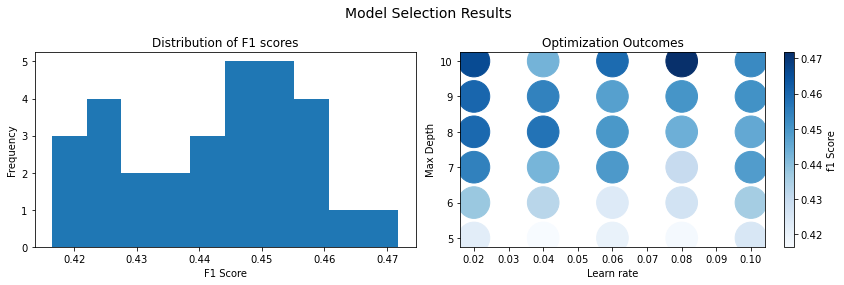

In [25]:
X = [x[0] for x in all_params]
Y = [x[1] for x in all_params]
Z = np.array([x[2] for x in all_params])

plt.set_cmap('Blues')
fig, ax = plt.subplots(1,2, figsize=(12,4))

im = ax[1].scatter(X,Y,c=Z, s=1000)
fig.colorbar(im, ax=ax[1]).set_label('f1 Score')
ax[1].set_xlabel('Learn rate')
ax[1].set_ylabel('Max Depth')
ax[1].title.set_text('Optimization Outcomes')

ax[0].hist(Z)
ax[0].set_xlabel('F1 Score')
ax[0].set_ylabel('Frequency')
ax[0].title.set_text('Distribution of F1 scores')

fig.suptitle("Model Selection Results", fontsize=14)
plt.tight_layout();

### Model Eval

Overall Performance vs Casino:
casino f1 for these games: 0.349, model f1: 0.449, skill increase = 28.4%
favorites are the same 76.37% of the time


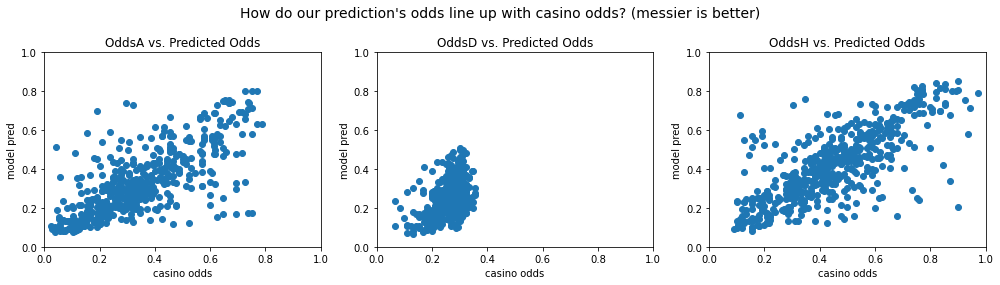

In [26]:
# how do we compare with casino predictions?
odds = game_df[['OddsH','OddsA','OddsD']][split:][~rand_idx]
odds_pred = odds.idxmax(axis=1).str[-1]
model_pred = model.predict(X_test)

casino_f1 = f1_score(y_test, odds_pred, average='macro')
model_f1 = f1_score(y_test, model_pred, average='macro')
improvement = (model_f1/casino_f1)-1
print("Overall Performance vs Casino:\n=============================")
print(f"casino f1 for these games: {casino_f1:.3f}, model f1: {model_f1:.3f}, skill increase = {improvement*100:.1f}%")
print(f"favorites are the same {(odds_pred==model_pred).mean()*100:.2f}% of the time")

fig, ax = plt.subplots(1,3,figsize=(14,4))
for i,j in enumerate(['OddsA','OddsD','OddsH']):
    x = odds[j]
    y = model.predict_proba(X_test)[:,i]
    ax[i].scatter(x,y)
    ax[i].set_ylabel('model pred')
    ax[i].set_xlabel('casino odds')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,1)
    ax[i].title.set_text(j + ' vs. Predicted Odds')
fig.suptitle("How do our prediction's odds line up with casino odds? (messier is better)", fontsize=14)
fig.tight_layout()

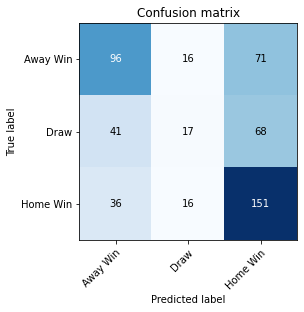

In [27]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          ax=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if ax==None:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax
_ = plot_confusion_matrix(y_test, model_pred, ['Away Win', 'Draw', 'Home Win'])

In [28]:
print("Classification Report:\n=====================")
print(classification_report(y_test, model.predict(X_test)))
#precision/recall: 
# - A model that produces no false positives has a precision of 1.0.
# - A model that produces no false negatives has a recall of 1.0.

Classification Report:
              precision    recall  f1-score   support

           A       0.55      0.52      0.54       183
           D       0.35      0.13      0.19       126
           H       0.52      0.74      0.61       203

    accuracy                           0.52       512
   macro avg       0.47      0.47      0.45       512
weighted avg       0.49      0.52      0.48       512



Model Calibration Report:
Away Brier Score	Casino: 0.2123	Model: 0.2022
Draw Brier Score	Casino: 0.1869	Model: 0.1856
Home Brier Score	Casino: 0.2201	Model: 0.2061


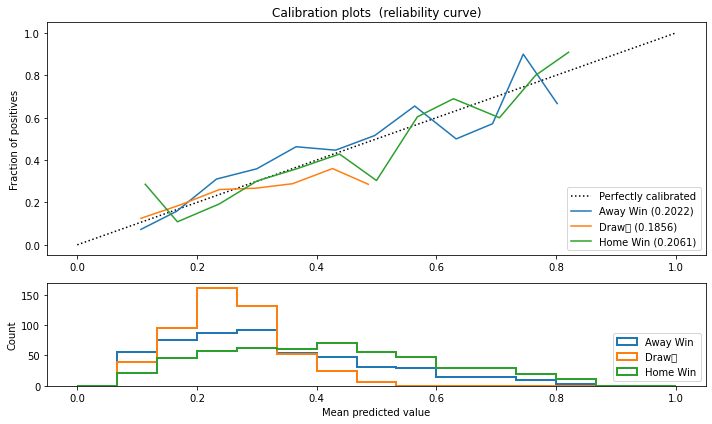

In [29]:
def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(10, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

model_proba = model.predict_proba(X_test)
data = [
    # truth, probabilities, labels
    (y_test=='A', model_proba[:,0], 'Away Win'),
    (y_test=='D', model_proba[:,1], 'Draw\t'),
    (y_test=='H', model_proba[:,2], 'Home Win'),
]
print("Model Calibration Report:\n========================")
for i, y in enumerate(['Away','Draw','Home']):
    b_model = brier_score_loss(y_test==y[0], model_proba[:,i])
    b_casino = brier_score_loss(y_test==y[0], odds['Odds'+y[0]])
    print(f'{y} Brier Score\tCasino: {b_casino:.4f}\tModel: {b_model:.4f}')
cal_curve(data, 15)

SHAP Model Explanability Values:


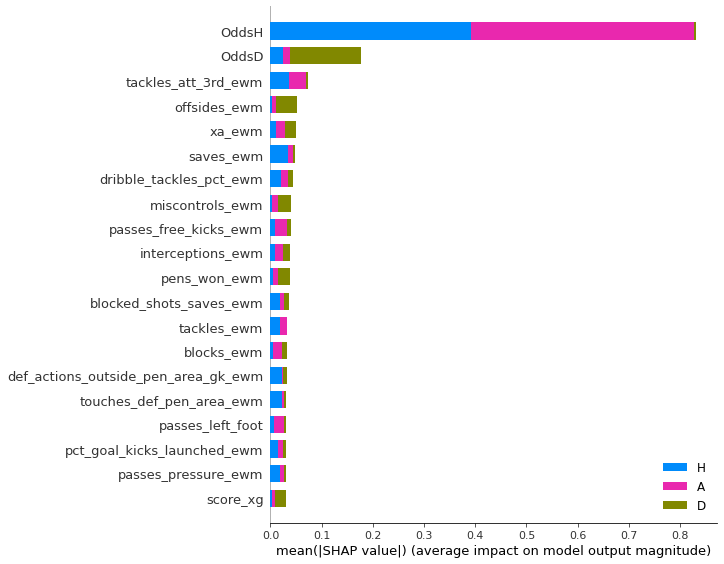

In [30]:
# patch model to work with shap
shap_model = pickle.load(open('tmp_model.pkl','rb'))
booster = shap_model.get_booster() 
model_bytearray = booster.save_raw()[4:]
booster.save_raw = lambda : model_bytearray

# shap explainer
print("SHAP Model Explanability Values:\n===============================")
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=shap_model.classes_)


In [31]:
pickle.dump(model,open('xgb_model.pkl','wb'))